In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('Housing.csv')
df.head()

In [ ]:
df.describe()

In [ ]:
df.info()


#### Exploring Price (Target Variable)

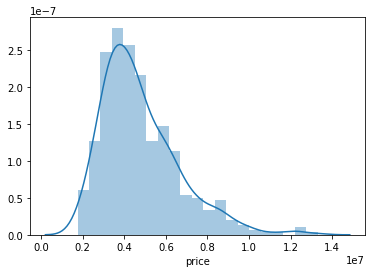

In [445]:
sns.distplot(df['price'])
plt.show()

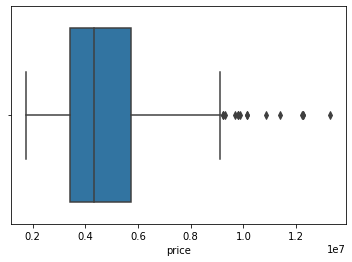

In [446]:
sns.boxplot(df['price'])
plt.show()

In [447]:
df['lprice'] = np.log(df['price'])

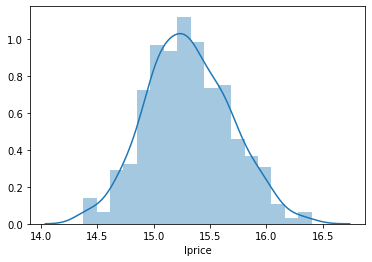

In [448]:
sns.distplot(df['lprice'])
plt.show()

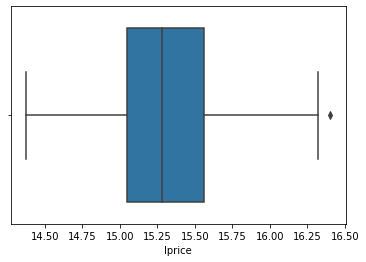

In [449]:
sns.boxplot(df['lprice'])
plt.show()

#### Exploring Area

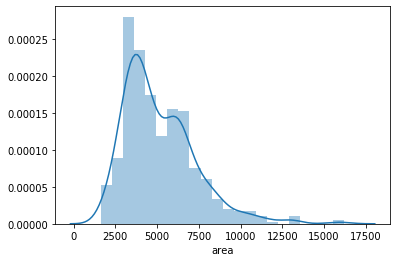

In [450]:
sns.distplot(df['area'])
plt.show()

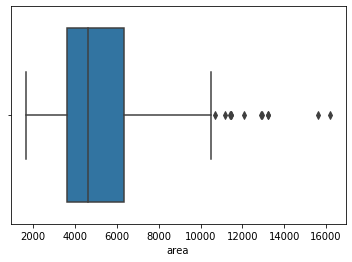

In [451]:
sns.boxplot(df['area'])
plt.show()

In [452]:
q1 = df['area'].quantile(0.25)
q3 = df['area'].quantile(0.75)
iqr = q3-q1

df = df[~(df['area']>(q3+1.5*iqr))]

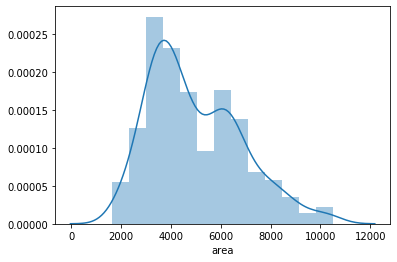

In [453]:
sns.distplot(df['area'])
plt.show()

#### Exploratory Data Analysis

###### Area and Price

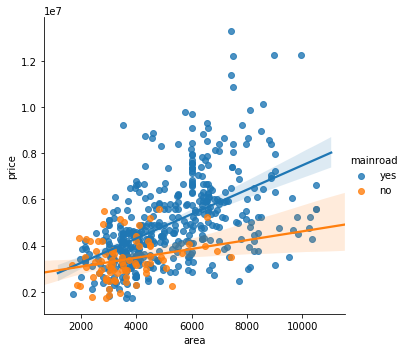

In [454]:
sns.lmplot(x='area', y='price', hue = 'mainroad', data=df)
plt.show()

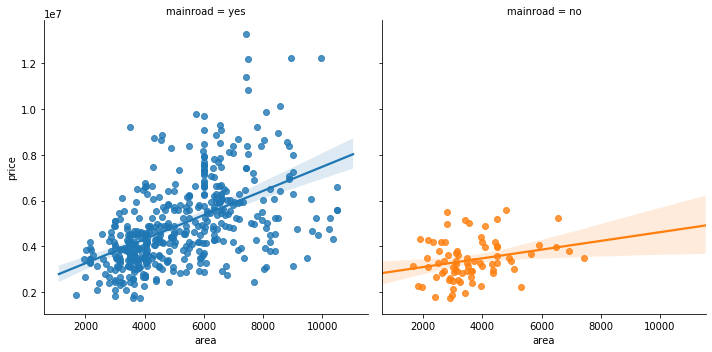

In [455]:
sns.lmplot(x='area', y='price', col='mainroad', hue = 'mainroad', data=df)
plt.show()

#### price and furnishingstatus

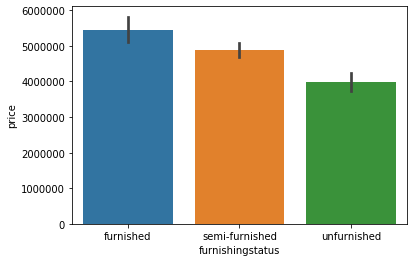

In [456]:
sns.barplot(x='furnishingstatus', y='price', data=df)
plt.show()

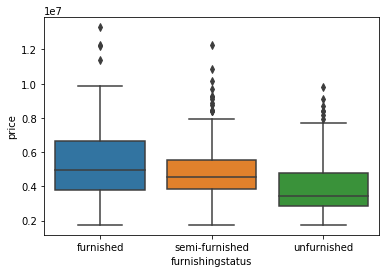

In [457]:
sns.boxplot(x='furnishingstatus', y='price', data=df)
plt.show()

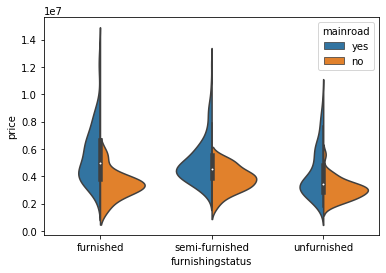

In [458]:
sns.violinplot(x='furnishingstatus', y='price', hue='mainroad',
               split=True, data=df)
plt.show()

### Model Building

In [459]:
df[['bathrooms', 'stories', 'parking']] = df[['bathrooms', 'stories', 'parking']].astype(object)

###### we will treat the above variables are object as the range values of the above varaibles were too less

In [460]:
df['furnishingstatus'].value_counts()

semi-furnished    223
unfurnished       176
furnished         134
Name: furnishingstatus, dtype: int64

In [461]:
cat_cols = list(df.select_dtypes(include='object').columns)
cat_cols

['bathrooms',
 'stories',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'parking',
 'prefarea',
 'furnishingstatus']

In [462]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 544
Data columns (total 21 columns):
price                              533 non-null int64
area                               533 non-null int64
bedrooms                           533 non-null int64
lprice                             533 non-null float64
bathrooms_2                        533 non-null uint8
bathrooms_3                        533 non-null uint8
bathrooms_4                        533 non-null uint8
stories_2                          533 non-null uint8
stories_3                          533 non-null uint8
stories_4                          533 non-null uint8
mainroad_yes                       533 non-null uint8
guestroom_yes                      533 non-null uint8
basement_yes                       533 non-null uint8
hotwaterheating_yes                533 non-null uint8
airconditioning_yes                533 non-null uint8
parking_1                          533 non-null uint8
parking_2                    

In [464]:
y = df['lprice']
yo = df['price']/100000
X = df.drop(['price', 'lprice'], axis=1)

In [482]:
yo.describe()

count    533.000000
mean      47.269952
std       18.512508
min       17.500000
25%       34.300000
50%       43.050000
75%       56.525000
max      133.000000
Name: price, dtype: float64

In [465]:
Xp = X.copy()

In [466]:
Xp.head()

,area,bedrooms,bathrooms_2,bathrooms_3,bathrooms_4,stories_2,stories_3,stories_4,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,parking_1,parking_2,parking_3,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,7420,4,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0
1,8960,4,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0
2,9960,3,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,1,0
3,7500,4,1,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0
4,7420,4,0,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0,0


In [467]:
Xp = Xp.assign(const=1)

## Machine Learning

In [468]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.30, random_state=1)

In [469]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()

result = lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [470]:
print ('R-square of Train: ', r2_score(y_train, y_train_pred))
print ('R-square of Test: ', r2_score(y_test, y_test_pred))

R-square of Train:  0.7274783723271575
R-square of Test:  0.6081771562513784


#### Application of RFE to reduce over-fitting

In [471]:
from sklearn.feature_selection import RFE

In [472]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=2)

rfe.fit(Xp, y)

y_pred = rfe.predict(Xp)
r2 = r2_score(y, y_pred)

cols = pd.DataFrame(list(zip(Xp.columns, rfe.support_, rfe.ranking_)), 
                   columns=['cols', 'select', 'rank'])

cols = cols[cols['select']==True]
cols = list(cols.loc[:,'cols'])
print(r2, cols)

0.031518475095419274 ['bathrooms_3', 'bathrooms_4']


In [473]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, KFold

params = [{'n_features_to_select': list(range(5,30))}]

lr = LinearRegression()
rfe = RFE(lr)

folds = KFold(n_splits=3, shuffle=True,  random_state=1)
model_cv = GridSearchCV(rfe, param_grid=params, cv=folds)

model_cv.fit(Xp, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20, 21, 22, 23, 24, 25, 26,
                                                   27, 28, 29]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [474]:
model_cv.best_params_

{'n_features_to_select': 19}

In [475]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=19)

rfe.fit(Xp, y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=19, step=1, verbose=0)

In [476]:
cols = pd.DataFrame(list(zip(Xp.columns, rfe.support_, rfe.ranking_)), 
                   columns=['cols', 'select', 'rank'])

In [477]:
cols = cols[cols['select']==True]
cols = list(cols.loc[:,'cols'])
cols

['area',
 'bedrooms',
 'bathrooms_2',
 'bathrooms_3',
 'bathrooms_4',
 'stories_2',
 'stories_3',
 'stories_4',
 'mainroad_yes',
 'guestroom_yes',
 'basement_yes',
 'hotwaterheating_yes',
 'airconditioning_yes',
 'parking_1',
 'parking_2',
 'parking_3',
 'prefarea_yes',
 'furnishingstatus_semi-furnished',
 'furnishingstatus_unfurnished']

In [478]:
from sklearn.model_selection import train_test_split

Xp_5 = Xp.loc[:, cols] 

X_train, X_test, y_train, y_test = train_test_split(Xp_5, y, 
                                    test_size=0.30, random_state=1)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()

result = lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [479]:
print ('R-square of Train: ', r2_score(y_train, y_train_pred))
print ('R-square of Test: ', r2_score(y_test, y_test_pred))

R-square of Train:  0.7274783723271576
R-square of Test:  0.6081771562513785
